In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import os
import random
import json

In [2]:
img_path = "/home/nplab/NPLAB-NAS/Datasets/Face-data/modi_data/img"
mask_path = "/home/nplab/NPLAB-NAS/Datasets/Face-data/modi_data/final_mask"

ann = "/home/nplab/NPLAB-NAS/Datasets/Face-data/New_Face_Data/merge/ann"

## Images on which pores and wrinkles will be drawn
newly_captured_left_img_path = "/home/nplab/NPLAB-NAS/Datasets/NewSkinDataset/Newly_captured_photos/original_images/left_images"
newly_captured_right_img_path = "/home/nplab/NPLAB-NAS/Datasets/NewSkinDataset/Newly_captured_photos/original_images/right_images"

## Save directory for augmented images and masks
save_aug_image_path = "/home/nplab/NPLAB-NAS/Datasets/NewSkinDataset/Newly_captured_photos/blended_aug/images"
save_aug_masks_path = "/home/nplab/NPLAB-NAS/Datasets/NewSkinDataset/Newly_captured_photos/blended_aug/masks"


In [3]:
extensions = ('.png','.jpg','.jpeg')
img_list = sorted([os.path.join(img_path, img) for img in os.listdir(img_path) if img.lower().endswith(extensions)])
mask_list = sorted([os.path.join(mask_path,img) for img in os.listdir(mask_path) if img.lower().endswith(extensions)])

newly_captured_img_list = []
newly_captured_left_img = sorted([os.path.join(newly_captured_left_img_path, img) for img in os.listdir(newly_captured_left_img_path) if img.lower().endswith(extensions)])
newly_captured_right_img = sorted([os.path.join(newly_captured_right_img_path, img) for img in os.listdir(newly_captured_right_img_path) if img.lower().endswith(extensions)])

newly_captured_img_list.extend(newly_captured_left_img)
newly_captured_img_list.extend(newly_captured_right_img)


In [4]:
len(newly_captured_img_list)

150

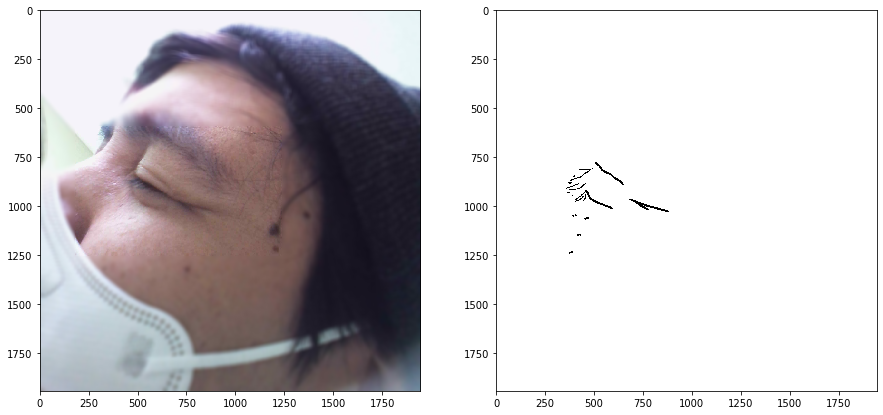

In [5]:
ori_img = cv2.imread(os.path.join(img_path,img_list[10] ))
ori_rgb_image = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(os.path.join(mask_path,mask_list[10] ))
mask[mask == 0] = 255


fig, ax = plt.subplots(1,2, figsize = (15,15))
ax[0].imshow(ori_rgb_image)
ax[1].imshow(mask)

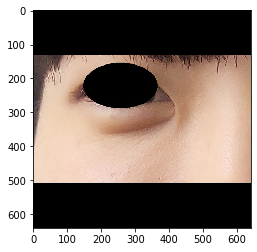

In [6]:
img = cv2.imread(newly_captured_img_list[10])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [7]:
def check_ann(base_name):
    possible_extensions = [".png", ".PNG", ".jpg", ".JPG", ".JPEG", ".jpeg"]  # List of possible extensions

    for extension in possible_extensions:
        ann_path = os.path.join(ann, base_name + extension + ".json")
        if os.path.exists(ann_path):
            return ann_path  # Return the first valid extension found

    return None  # Return None if no valid extension is found

In [8]:
def cropped_ori_img_mask(img_path, mask_path):
    filename = os.path.basename(img_path)
    base_name = os.path.splitext(filename)[0]
    ann_path = check_ann(base_name)
    
    read_ann_json = open(ann_path)
    loaded_ann_json =json.load(read_ann_json)
    
    read_img = cv2.imread(img_path)
    read_mask = cv2.imread(mask_path)
    read_mask[read_mask == 3] = 0
    
    for i, val in enumerate(loaded_ann_json["objects"]):
        if val['geometryType'] == 'rectangle':
            roi_x = val['points']['exterior'][0][0]
            roi_y = val['points']['exterior'][0][1]
            roi_xmax = val['points']['exterior'][1][0]
            roi_ymax = val['points']['exterior'][1][1]
    crop_x = roi_x
    crop_xmax = roi_xmax
    crop_y = roi_y
    crop_ymax = roi_ymax
    crop_w = crop_xmax - crop_x
    crop_h = crop_ymax - crop_y
    
    crop_new_img = read_img[crop_y: crop_y + crop_h, crop_x: crop_x + crop_w]
    crop_new_mask = read_mask[crop_y: crop_y + crop_h, crop_x: crop_x + crop_w]
    
    resized_img = cv2.resize(crop_new_img, (640,640))
    resized_mask = cv2.resize(crop_new_mask, (640,640))
    
    return resized_img, resized_mask

In [9]:
def get_roi(image):
    roi = np.nonzero(image)
    # Calculate the bounding box (xmin, ymin, xmax, ymax)
    xmin = np.min(roi[1])
    ymin = np.min(roi[0])
    xmax = np.max(roi[1])
    ymax = np.max(roi[0])
    
    return xmin,ymin,xmax,ymax

In [10]:
def find_pore_wrinkle(mask_path):
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.cvtColor(mask_path, cv2.COLOR_BGR2GRAY)
    # Extract the pore and wrinkle masks
    pore_mask = (mask == 1)
    wrinkle_mask = (mask == 2)
    # Find contours for the pore mask
    pore_contours, _ = cv2.findContours(pore_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Find contours for the wrinkle mask
    wrinkle_contours, _ = cv2.findContours(wrinkle_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Generate a random number between 20 and 30
    num_pores = random.randint(25, 35)
    if (len(pore_contours) > num_pores):
        # Randomly select pore contours
        selected_pores = random.sample(pore_contours, num_pores)
    else:
        selected_pores = random.sample(pore_contours, len(pore_contours))
        
    # Generate a random number between 20 and 30
    num_wrinkles = random.randint(20, 30)
    if (len(wrinkle_contours) > num_wrinkles):
        # Randomly select 10 pore contours
        selected_wrinkles = random.sample(wrinkle_contours, num_wrinkles)
    else:
        selected_wrinkles = random.sample(wrinkle_contours, len(wrinkle_contours))
        
    
    return selected_pores, selected_wrinkles

In [11]:
def draw_wrinkle(ori_img, img_to_draw, wrinkles):
    
    xmin,ymin,xmax,ymax =get_roi(img_to_draw)
    white = 255
    img_size = 640

    shifted_wrinkles_image = np.zeros((img_size,img_size), dtype=np.uint8)
    shifted_wrinkles_mask  = np.zeros((img_size,img_size), dtype=np.uint8)

    roi_x = xmin + 20
    roi_y = ymin + (ymax-ymin)//2 + 20
    xmax = xmax - 20
    ymax = ymax - 20

    roi_w = xmax - roi_x
    roi_h = ymax - roi_y
    #roi_w = xmax - xmin
    #roi_h = ymax - ymin

    for wrinkle in wrinkles:
        single_mask  = np.zeros((img_size,img_size), dtype=np.uint8)
        single_image = np.zeros((img_size,img_size), dtype=np.uint8)

        cv2.drawContours(single_mask, [wrinkle], -1,white, thickness=cv2.FILLED)
        single_image = cv2.copyTo(ori_img, single_mask)


        x, y, w, h = cv2.boundingRect(wrinkle)
        # Generate random offsets within the defined rectangular region
        offset_x = random.randint(0, roi_w - w)
        offset_y = random.randint(0, roi_h - h)

        M = np.float32([[1, 0, -x + roi_x + offset_x], 
                        [0, 1, -y + roi_y + offset_y]])
        single_image = cv2.warpAffine(single_image, M, (img_size,img_size))
        single_image = (255*single_image).astype(np.uint8)
        single_mask  = cv2.warpAffine(single_mask, M, (img_size,img_size))
        single_mask  = (255*single_mask).astype(np.uint8)

        shifted_wrinkles_image = cv2.copyTo(single_image, single_mask, dst=shifted_wrinkles_image)
        shifted_wrinkles_mask  = cv2.copyTo(single_mask, single_mask, dst=shifted_wrinkles_mask)
        shifted_wrinkles_mask[shifted_wrinkles_mask > 0] = 2
        
    return shifted_wrinkles_image, shifted_wrinkles_mask
    

In [12]:
def draw_pore(ori_img, img_to_draw, wrinkle_img, wrinkle_mask, pores):
    
    shifted_pore_wrinkles_image = wrinkle_img
    shifted_pore_wrinkles_mask = wrinkle_mask
    
    xmin,ymin,xmax,ymax =get_roi(img_to_draw)
    white = 255
    img_size = 640
    
    roi_x = xmin + 20
    roi_y = ymin + (ymax-ymin)//2 + 20
    xmax = xmax - 20
    ymax = ymax - 20

    roi_w = xmax - roi_x
    roi_h = ymax - roi_y
    
    for pore in pores:
        single_mask  = np.zeros((img_size,img_size), dtype=np.uint8)
        single_image = np.zeros((img_size,img_size), dtype=np.uint8)

        cv2.drawContours(single_mask, [pore], -1,white, thickness=cv2.FILLED)
        single_image = cv2.copyTo(ori_img, single_mask)


        x, y, w, h = cv2.boundingRect(pore)
        # Generate random offsets within the defined rectangular region
        offset_x = random.randint(0, roi_w - w)
        offset_y = random.randint(0, roi_h - h)

        M = np.float32([[1, 0, -x + roi_x + offset_x], 
                        [0, 1, -y + roi_y + offset_y]])
        single_image = cv2.warpAffine(single_image, M, (img_size,img_size))
        single_image = (255*single_image).astype(np.uint8)
        single_mask  = cv2.warpAffine(single_mask, M, (img_size,img_size))
        single_mask  = (255*single_mask).astype(np.uint8)

        shifted_pore_wrinkles_image = cv2.copyTo(single_image, single_mask, dst=shifted_pore_wrinkles_image)
        shifted_pore_wrinkles_mask  = cv2.copyTo(single_mask, single_mask, dst=shifted_pore_wrinkles_mask)
        
    return shifted_pore_wrinkles_image, shifted_pore_wrinkles_mask

In [14]:
##final Code
count = 0
for img in newly_captured_img_list:
    success = False
    while not success:
        try:
            img_to_draw = cv2.imread(img)
            ori_image_path = random.choice(img_list)
            base_file = os.path.basename(img)
            ori_img_name = os.path.splitext(os.path.basename(ori_image_path))[0]
            ori_mask_path = os.path.join(mask_path, f'{ori_img_name}.png')
            original_image, original_mask = cropped_ori_img_mask(ori_image_path, ori_mask_path)
            unique_values = np.unique(original_mask)
            if np.all(np.isin([1, 2], unique_values)):
                ##find selected pore and wrinkles
                pores, wrinkles = find_pore_wrinkle(original_mask)
                ##draw wrinkles to new image
                wrinkle_image, wrinkle_mask = draw_wrinkle(original_image, img_to_draw, wrinkles)
                #draw pores to new image
                pore_wrinkle_image, pore_wrinkle_mask = draw_pore(original_image, img_to_draw, wrinkle_image, wrinkle_mask, pores)
                blended_img = cv2.add(-1*pore_wrinkle_image*0.10, img_to_draw*0.90, dst=None).astype(np.uint8)
                cv2.imwrite(os.path.join(save_aug_image_path, base_file), blended_img)
                cv2.imwrite(os.path.join(save_aug_masks_path, base_file), pore_wrinkle_mask)
                print(np.unique(pore_wrinkle_mask))
                blended_img_rgb = cv2.cvtColor(blended_img, cv2.COLOR_BGR2RGB)
                fig, ax = plt.subplots(1, 2, figsize=(15, 15))
                ax[0].imshow(blended_img_rgb)
                ax[1].imshow(pore_wrinkle_mask)
                print(f"Success:{count}")
                count = count + 1
                success = True  # Set success to True if the code executed without exceptions
        except Exception as e:
            print(f"Error in {ori_img_name}: {str(e)}")
